# BilbyAnalysis.ipynb

Maria Okounkova (mokounkova@flatironinstitute.org)

### Notebook for the analysis of Bilby runs, including corner plots and evidences

### Imports

In [35]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import corner
from astropy import constants as const
from math import pi
import pesummary
from pesummary.io import read
import json
from math import sqrt
import os.path
from scipy.optimize import curve_fit
from ipynb.fs.full.Auxiliary import SubtractPeakTime, EllinKm, ComputeOverlap, ComputeMultiDetectorOverlap
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset

# Plot parameters
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'
matplotlib.rcParams['axes.labelsize'] = 24

t_gps = 1126259462.0
t_start = t_gps - 2.0

### Functions for injection values, Bayes factors, evidences, etc

In [36]:
def GetTruthDict(p):
    """ Return a dictionary of truth values for corner plots from the parameters.json file 
        corresponding to the injected parameters, where p is the path to the file """
    TruthDict = {}
    
    f = open(p + '/parameters.json')
    params = json.load(f)
    TruthDict['chirp_mass'] = params['chirp_mass']
    TruthDict['mass_ratio'] = params['mass_ratio']
    TruthDict['mass'] = params['mass']
    TruthDict['total_mass'] = params['mass']
    TruthDict['luminosity_distance'] = params['dist_mpc']
    TruthDict['a_1'] = np.abs(params['a_1'][2]) ## assumes aligned spin for now
    TruthDict['a_2'] = np.abs(params['a_2'][2])
    TruthDict['dec'] = params['dec']
    TruthDict['ra'] = params['ra']
    TruthDict['theta_jn'] = params['theta']
    TruthDict['tilt_1'] = 0.0
    TruthDict['tilt_2'] = np.pi
    TruthDict['phase'] = params['phi']
    TruthDict['psi'] = params['pol'] 
    TruthDict['m_1'] = params['m_1']
    TruthDict['m_2'] = params['m_2']
    TruthDict['chi_eff'] = params['chi_eff']
    TruthDict['chi_p'] = 0.0 ## Since this is a non-precessing run
    f.close()
    return TruthDict

def GetEvidences(p):
    """ Generate a .dat file for the evidences if it doesn't exist, 
        reading from the json file.
        Returns log_evidence log_evidence_err log_noise_evidence log_bayes_factor """
    
    name = p + "/evidences.dat"
 
    if not os.path.isfile(name):
        
        print("Generating evidences.dat from result.json file")
        
        f_res = open(p + '/fast_tutorial_result.json')
        data = json.load(f_res)
        f_res.close()
      
        f_out = open(name, 'w')
        f_out.write("# log_evidence log_evidence_err log_noise_evidence log_bayes_factor \n")
        f_out.write("%f %f %f %f" % (data['log_evidence'], data['log_evidence_err'], data['log_noise_evidence'], data['log_bayes_factor']))
        f_out.close()

    return np.loadtxt(name, comments="#",usecols=([0,1,2,3]),unpack=True) 

def Ell_SNR_String(ell_string, mass, snr):
    """ For dCS parameters, convert from the string corresponding
        to the dimensionless ell value (like `0p0`) to a value
        in kilometers (like 0.0 [km]) """
    ell = float(ell_string.replace('p', '.'))
    mass_msun = mass * const.M_sun
    phys_ell_km = ell * mass_msun * const.G /(const.c**2) / 1000
    string = "%.f km, " % (phys_ell_km.value) + snr
    return string

def Ell_String(ell_string, mass):
    """ For dCS parameters, convert from the string corresponding
        to the dimensionless ell value (like `0p0`) to a value
        in kilometers (like 0.0 [km]) """
    ell = float(ell_string.replace('p', '.'))
    mass_msun = mass * const.M_sun
    phys_ell_km = ell * mass_msun * const.G /(const.c**2) / 1000
    string = "%.f km" % (phys_ell_km.value)
    return string

def SummaryPageFile(name):
    return "/home/maria.okounkova/BeyondGRAnalysis/BilbyPE/" + name + \
        "/summary_pages/samples/posterior_samples.h5"

RangeDict = {'mass_ratio': (0.7, 1.0), 'total_mass' : (65.0, 71.0), 'chi_eff' : (-0.15, 0.15), 'chi_p' : (0.0, 1.0), 'luminosity_distance' : (0, 3000)}

def GetBWDir(p):
    return p + '/BayesWave/Run/trigtime_1126259462.000000000_0.0_0.0_0/'

def GetBWInjectedData(p, det = "H1"):
    """ Given a BW run directory and a detector, read in the injected time domain waveform """
    
    base_dir = GetBWDir(p)
    
    f = base_dir + 'post/whitened_data_' + det + '.dat'
    data = np.loadtxt(f)
    
    ## Compute the corresponding time array 
    s_rate = 2048
    dt = 1.0/s_rate
    time = np.array([dt * t for t in range(len(data))])
 
    time = time + t_start
    return time, data

def GetBWInjectedFrequencyDomainWaveform(p, det):
    """ 
    Given a BW run directory and a detector, read in the injected BW freq domain waveform
    
    Get the injected frequency domain waveform from the same
    place that megaplot.py gets it from. See lines 541 - 543 of
    megaplot.py in plot_full_spectro() method """

    base_dir = GetBWDir(p)
 
    f = base_dir + "waveforms/fourier_domain_data_" + det + ".dat"
    freq, re, im = np.loadtxt(f, comments="#",usecols=([0,1,2]),unpack=True)
    return freq, re + 1j*im   

def GetBWMedianData(p, det = "H1"):
    """ Given a BW run directory and a detector, read in the median time domain waveform 
        and confidence intervals (90% and 50%)"""
    
    base_dir = GetBWDir(p)

    ## Grab Livingston data
    f = base_dir + "post/signal/signal_median_time_domain_waveform_" + det + ".dat"
    time, d1, d2, d3, d4, d5 = np.loadtxt(f, comments="#",usecols=([0,1,2,3,4,5]),unpack=True)
    
    time = time + t_start
    return time, d1, d2, d3, d4, d5

def GetBWTimes(p, det = "H1"):
    """ Given a BW run directory and a detector, read in Bayeswave time axis """
    
    base_dir = GetBWDir(p)

    ## Grab Livingston data
    f = base_dir + "post/signal/signal_median_time_domain_waveform_" + det + ".dat"
    time = np.loadtxt(f, comments="#",usecols=([0]),unpack=True)
    
    time = time + t_start
    return time

def GetBWFrequencyDomainWaveform(p, detector):
    """ 
    Given a BW run directory and a detector, read in the recovered BW freq domain waveform
    
    Ignore the first column, it's wrong. The second line is the median with alternating real and imaginary waveforms
    The first line is h_R at f=0, the second line is h_I at f=0 etc """
    
    base_dir = GetBWDir(p)
 
    f = base_dir + "post/signal/signal_median_frequency_domain_waveform_" \
                                                               + detector + ".dat"
    freq, d1, d2, d3, d4, d5 = np.loadtxt(f, comments="#",usecols=([0,1,2,3,4,5]),unpack=True)
    length = len(freq)
    
    ## Grab the true frequency range
    freq = freq[0:int(length/2)]
    
    ## Now split up the median into real and imaginary parts
    d1 = d1[0::2] + 1j*d1[1::2]
    d2 = d2[0::2] + 1j*d2[1::2]
    d3 = d3[0::2] + 1j*d3[1::2]
    d4 = d4[0::2] + 1j*d4[1::2]
    d5 = d5[0::2] + 1j*d5[1::2]
    return freq, d1, d2, d3, d4, d5

def GetBilbyData(p, det = "H1"):
    """ Given a directory, grab the whitened Bilby waveforms """
    bilby_p = p + '/LI_reconstruct/'
    time, MAP, lo, hi = np.loadtxt(bilby_p + det + '_summary_waveforms_samples.dat', \
        comments="#",usecols=([0,2,3,5]),unpack=True)
    return time, MAP, lo, hi

def GetBilbyFrequencyDomainData(p, det):
    """ Given a directory, grab that whitened Bilby waveforms """
    bilby_p = p + '/LI_reconstruct/'
    freq, ml = np.loadtxt(bilby_p + det + '_summary_waveforms_F_samples.dat', \
        comments="#",usecols=([0,6]),unpack=True)
    return freq, ml

def GetBilbyReconstruction(p, det = 'L1'):

    #base_dir = '/home/maria.okounkova/BeyondGRAnalysis/BilbyPE/' 
    bi_p = p + '/LI_reconstruct/'
    bw_p = p + '/BayesWave/Run/trigtime_1126259462.000000000_0.0_0.0_0/'
    
    h_bw_inj = np.loadtxt(bw_p + 'post/whitened_data_' + det + '.dat')
    t_bw_inj = np.array([1.0/2048 * t for t in range(len(h_bw_inj))])
    t_bw_inj = t_bw_inj + t_start
    
    t_bi, map_bi, lo_bi, hi_bi = \
        np.loadtxt(bi_p + det + '_summary_waveforms_samples.dat', \
        comments="#",usecols=([0,1,3,5]),unpack=True)
    
    return t_bw_inj, h_bw_inj, t_bi, map_bi, lo_bi, hi_bi

def GetBilbyTimes(p, det = 'L1'):

    bi_p = p + '/LI_reconstruct/'
    
    t_bi = np.loadtxt(bi_p + det + '_summary_waveforms_samples.dat', \
        comments="#",usecols=([0]),unpack=True)
    
    return t_bi

In [37]:
## Grab the mass
p = '/home/maria.okounkova/BeyondGRAnalysis/BilbyPE/PHENOM_dCS_0p0_75'
TruthDict = GetTruthDict(p)
print(TruthDict['luminosity_distance'])
mass = TruthDict['mass']

601.0372365294345


### One dimensional histograms

mass_ratio, chirp_mass, a_1, a_2, tilt_1, tilt_2, phi_12, phi_jl, luminosity_distance, dec, ra, theta_jn, psi, phase, geocent_time, log_likelihood, log_prior, redshift, comoving_distance, inverted_mass_ratio, mass_1, mass_2, total_mass, symmetric_mass_ratio, mass_1_source, mass_2_source, total_mass_source, chirp_mass_source, iota, spin_1x, spin_1y, spin_1z, spin_2x, spin_2y, spin_2z, phi_1, phi_2, chi_p, chi_p_2spin, chi_eff, beta, psi_J, cos_tilt_1, cos_tilt_2, H1_time, L1_time, V1_time, cos_theta_jn, viewing_angle, cos_iota

In [4]:
def Histogram(param, SNR = '75'):

    #ells = ['0p0', '0p25', '0p3', '0p33', '0p35', '0p37']
    ells = ['0p33', '0p35', '0p37']
    snrs = [SNR for ell in ells]
    #snrs = ['25', '75', '125']
    #ells = ['0p0' for snr in snrs]
    colors = sns.color_palette('gnuplot2', n_colors=len(snrs) + 1)
    
    fig, ax = plt.subplots(1, figsize = (10, 5.5))
    print("SNR =", SNR)
    
    for ell, snr, color in zip(ells, snrs, colors):
        
        file_name = SummaryPageFile('PHENOM_dCS_' + ell + '_' + snr)
        data = read(file_name)
        samples_dict = data.samples_dict
        posterior_samples = samples_dict["summary_pages"]
        posterior_samples.plot(param, kde=True, color = color, label = Ell_String(ell, mass), fig = fig, plot_percentile = False, title = False)
        
    plt.xlim(RangeDict[param])
    leg = plt.legend(loc = 'upper right', title = '$\ell$', fontsize = 24)
    plt.setp(leg.get_title(), fontsize = 24)
    plt.grid(True)
    ax.tick_params(axis='both', labelsize=24)
    xlbl = ax.xaxis.get_label()
    ax.set_xlabel(xlbl.get_text(), fontsize=30)
    ylbl = ax.yaxis.get_label()
    ax.set_ylabel(ylbl.get_text(), fontsize=30)
    
    ax.axvline(TruthDict[param], color = 'black', ls = '--', lw = 3.0)
     
    plt.tight_layout()
    plt.savefig('kde_' + param + '_' + SNR + '.pdf')
    plt.show()
    
params_avail = ["mass_ratio", "chirp_mass", "a_1", "a_2", "tilt_1", "tilt_2", \
                "phi_12", "phi_jl", "luminosity_distance", "dec", "ra", \
                "theta_jn", "psi", "phase", "geocent_time", "total_mass", \
                "symmetric_mass_ratio", "iota", "phi_1", "phi_2", "chi_p", "chi_p_2spin", \
                "chi_eff", "beta", "psi_J", "cos_tilt_1", "cos_tilt_2", "H1_time", \
                "L1_time", "V1_time", "cos_theta_jn", "viewing_angle", "cos_iota"]

#Histogram("mass_ratio", SNR = '125')
#Histogram("chi_p", SNR = '125')
#Histogram("chi_p", SNR = '25')
#Histogram("chi_p", SNR = '50')
#Histogram("chi_p", SNR = '75')
#Histogram("chi_p", SNR = '100')
#Histogram("chi_eff", SNR = '125')
#Histogram("luminosity_distance", SNR = '125')


In [5]:
def HistogramSNR(param):
    """ Plot histograms for a variety of ell values, for a variety of SNRs """

    ells = ['0p0', '0p25', '0p3', '0p33', '0p35', '0p37']
    snrs = ['25', '50', '75', '100', '125']
    colors = sns.color_palette('gnuplot2', n_colors=len(ells) + 1)
    
    fig, axarr = plt.subplots(5, figsize = (10, 15), sharex = True)
   
    for snr, ax in zip(snrs, axarr):
    
        for ell, color in zip(ells, colors):

            print(snr, ell)
            file_name = SummaryPageFile('PHENOM_dCS_' + ell + '_' + snr)
            data = read(file_name)
            samples_dict = data.samples_dict
            posterior_samples = samples_dict["summary_pages"]
            posterior_samples.plot(param, kde=True, color = color, label = "%d" % EllinKm(ell, mass), fig = fig, ax = ax, plot_percentile = False, title = False)

        if snr == snrs[0]:
            ax.set_xlim(RangeDict[param])
            leg = ax.legend(loc = 'lower left', title = '$\ell$ [km]', fontsize = 18, labelspacing=0.1, framealpha=1.0)
            plt.setp(leg.get_title(), fontsize = 20)
        
        ax.grid(True)
        ax.tick_params(axis='both', labelsize=24)
        xlbl = ax.xaxis.get_label()
        ax.set_xlabel(xlbl.get_text(), fontsize=30)
        ylbl = ax.yaxis.get_label()
        ax.set_ylabel(ylbl.get_text(), fontsize=24)
    
        ax.text(0.02, 0.9, "SNR = " + snr, horizontalalignment='left', verticalalignment='center', transform=ax.transAxes, fontsize=20)
        ax.axvline(TruthDict[param], color = 'black', ls = '--', lw = 3.0)
    
    plt.subplots_adjust(hspace=0.1)
    #plt.tight_layout()
    plt.savefig('SNR_kde_' + param + '.pdf')
    plt.show()
    

#HistogramSNR("chi_eff")

### Bilby results corner plot

In [6]:
def CornerPlot(SNR):
    """ Make a corner plot of Bilby runs on GR injections with various values of ell, 
        for a given value of SNR"""

    base = '/home/maria.okounkova/BeyondGRAnalysis/BilbyPE/'
    parameters = ['mass_ratio', 'total_mass', 'chi_p', 'chi_eff']
    
    ## Get the truth dictionary 
    p = '/home/maria.okounkova/BeyondGRAnalysis/BilbyPE/PHENOM_dCS_0p0_' + SNR
    TruthDict = GetTruthDict(p)
    print(TruthDict['luminosity_distance'])
    mass = TruthDict['mass']
    
    truths = [TruthDict[param] for param in parameters]
    ranges = [RangeDict[param] for param in parameters]
    print(truths)
    dim = len(parameters) 

    ells = ['0p0', '0p25', '0p3', '0p33', '0p35', '0p37']
    #ells = ['0p0', '0p33'] #, '0p35', '0p37']
    colors = sns.color_palette('gnuplot2_r', n_colors=len(ells))
    #colors = ["orange", "red", "blue", "black"]
    #colors = ['#46cad4', '#f54242']
    
    fig, ax_arr = plt.subplots(dim, dim, figsize=(10, 10))
    handles = []
    
    for ell, c, pic in zip(ells, colors, range(len(ells))):
        
        file_name = SummaryPageFile('PHENOM_dCS_' + ell + '_' + SNR)
        print(pic, file_name)
        data = read(file_name)
        samples_dict = data.samples_dict
        posterior_samples = samples_dict["summary_pages"]
        posterior_samples.plot(type="corner",
                             parameters=parameters, fig = fig, color = c, truths=truths, truth_color='black', \
                               quantiles=[], range=ranges, kde=True, smooth=1.5)
    
        ## Dealing with the legend
        l = ax_arr[0][dim-1].plot([0,0], [0,0], label=r"%d" % EllinKm(ell, mass) + " km", color = c)
        handles.append(l[0])

        ## Plot the injected values myself
        legend = ax_arr[0][3].legend(handles=handles, frameon=False, title = r'$\ell$ [km], SNR = ' + SNR, loc = 'upper center', fontsize=24)

        for i in range(4):
            ax_arr[i][0].set_xlim(RangeDict['mass_ratio'])
            ax_arr[i][1].set_xlim(RangeDict['total_mass'])
            ax_arr[i][2].set_xlim(RangeDict['chi_p'])
            ax_arr[i][3].set_xlim(RangeDict['chi_eff'])

        ax_arr[1][0].set_ylim(RangeDict['total_mass'])
        
        ax_arr[2][0].set_ylim(RangeDict['chi_p'])
        ax_arr[2][1].set_ylim(RangeDict['chi_p'])
        
        ax_arr[3][0].set_ylim(RangeDict['chi_eff'])
        ax_arr[3][1].set_ylim(RangeDict['chi_eff'])
        ax_arr[3][2].set_ylim(RangeDict['chi_eff'])
        
        # ax_arr[4][0].set_ylim(RangeDict['chi_eff'])
        # ax_arr[4][1].set_ylim(RangeDict['chi_eff'])
        # ax_arr[4][2].set_ylim(RangeDict['chi_eff'])
        # ax_arr[4][3].set_ylim(RangeDict['chi_eff'])

        for ax in fig.get_axes():

            ax.tick_params(axis='y', direction='inout', labelsize=18)
            ax.tick_params(axis='x', direction='inout', labelsize=18)

        plt.setp(legend.get_title(),fontsize=24)

        for ax in fig.get_axes():
            ax.grid(False)
            xlbl = ax.xaxis.get_label()
            ax.set_xlabel(xlbl.get_text(), fontsize=30)
            ylbl = ax.yaxis.get_label()
            ax.set_ylabel(ylbl.get_text(), fontsize=30)

    #plt.tight_layout()
    #plt.savefig('dCSCorner_' + SNR + '_' + '000' + str(pic) + '.png')
    plt.savefig('dCSCorner_' + SNR + '.pdf')
    plt.show()

# CornerPlot('25') 
# CornerPlot('50') 
#CornerPlot('75') 
#CornerPlot('100') 
#CornerPlot('125')

### Plot frequency domain waveforms

In [7]:
def PlotFrequencyDomainWaveforms(bilby=False):
    """ Plot frequency domain waveforms, for bilby or the injection """
    
    det = "L1"
    base_dir = "/home/maria.okounkova/BeyondGRAnalysis/BilbyPE/"
    
    fig, ax = plt.subplots(1, figsize=(10, 7))

    mass = 68.0 ## Injected mass
    SNR = 125
    ell_arr = ["0p0", "0p25", "0p3", "0p33", "0p35", "0p37"]
    colors = sns.color_palette('mako_r', n_colors=len(ell_arr)+2)
    
    for ell, c in zip(ell_arr, colors):
        
        p = base_dir + "PHENOM_dCS_" + ell + "_" + str(SNR)
        label = r'%.1f' % EllinKm(ell, mass)
        
        if bilby: 
            freq, data = GetBilbyFrequencyDomainData(p, det)
            ax.plot(freq, np.abs(data), '-', color=c, lw = 2.5, alpha=1.0, label = label) 
            
        else:
            freq, data = GetBWInjectedFrequencyDomainWaveform(p, det)
            ax.plot(freq, np.abs(data), '-', color=c, lw = 2.5, alpha=1.0,  label = label) 
        
    ax.set_xlabel('Frequency (Hz)', fontsize = 24)
    plt.xscale('log')
    plt.yscale('log')
    plt.xlim(25, 1000)
    
    if bilby:
        ax.set_ylabel('Bilby Whitened waveform in LLO', ha='center', labelpad = 4.0, rotation='vertical', fontsize=24)
        #plt.ylim(1e-5, 5)
        plt.ylim(1e-27, 5e-23)
    else:
        ax.set_ylabel('Injected waveform in LLO', ha='center', labelpad = 4.0, rotation='vertical', fontsize=24)
        plt.ylim(1e-27, 5e-23)

    leg = ax.legend(fontsize=24, loc = 'lower left', ncol=1, frameon=False, title = '$\ell$ [km]')
    plt.setp(leg.get_title(),fontsize=22)
    for line in leg.get_lines():
        line.set_linewidth(4)
    ax.tick_params(axis='x', labelsize=24)
    ax.tick_params(axis = 'y', direction='out', length=10, width=1, colors='k',
               grid_color='b', grid_alpha=0.5, labelsize=24)
    ax.yaxis.get_offset_text().set_fontsize(24)

    plt.grid(True)
    plt.tight_layout()
    if bilby:
        plt.savefig('FrequencyWaveformsBilby.pdf')
    else:
        plt.savefig('FrequencyWaveformsInjected.pdf')
    plt.show()

#PlotFrequencyDomainWaveforms(bilby=True)
#PlotFrequencyDomainWaveforms()

### Plot time domain waveforms 

In [8]:
def PlotTimeDomainWaveforms():
    """ Plot time domain waveforms, for bilby or the injection """
    
    det = "L1" 
    base_dir = "/home/maria.okounkova/BeyondGRAnalysis/BilbyPE/"
    
    fig, ax = plt.subplots(1, figsize=(10, 7))

    mass = 68.0 ## Injected mass
    SNR = 125
    ell_arr = ["0p0", "0p3", "0p33", "0p35", "0p37"]
    colors = ["black"] + sns.color_palette('plasma', n_colors=len(ell_arr))
    #colors = ["black", "green", "red", "blue", "orange"]
    
    for ell, c in zip(ell_arr, colors):
        
        p = base_dir + "PHENOM_dCS_" + ell + "_" + str(SNR)
        label = r'%d' % EllinKm(ell, mass)
        
        time, MAP, lo, hi = GetBilbyData(p, det)
        ax.plot(time, MAP, '-', color=c, lw = 1.5, alpha=0.5, label = label) 
        
    ax.set_xlim(t_gps - 0.03, t_gps - 0.01)
    ax.set_ylim(-8, 8)
    ax.set_xlabel('Time (sec)', fontsize = 24)
    
    ax.set_ylabel('Bilby Whitened waveform in LLO', ha='center', labelpad = 4.0, rotation='vertical', fontsize=24)

    leg = ax.legend(fontsize=24, loc = 'best', ncol=1, frameon=False, title = '$\ell$ [km]')
    plt.setp(leg.get_title(),fontsize=22)
    for line in leg.get_lines():
        line.set_linewidth(4)
    ax.tick_params(axis='x', labelsize=24)
    ax.tick_params(axis = 'y', direction='out', length=10, width=1, colors='k',
               grid_color='b', grid_alpha=0.5, labelsize=24)
    ax.yaxis.get_offset_text().set_fontsize(24)

    plt.grid(True)
    plt.tight_layout()
    plt.savefig('WaveformsBilby.pdf')
    plt.show()

#PlotTimeDomainWaveforms()

### Plot Bilby and Bayeswave reconstruction with inset

['Injected', 'BayesWave', 'Bilby', 'Residual']


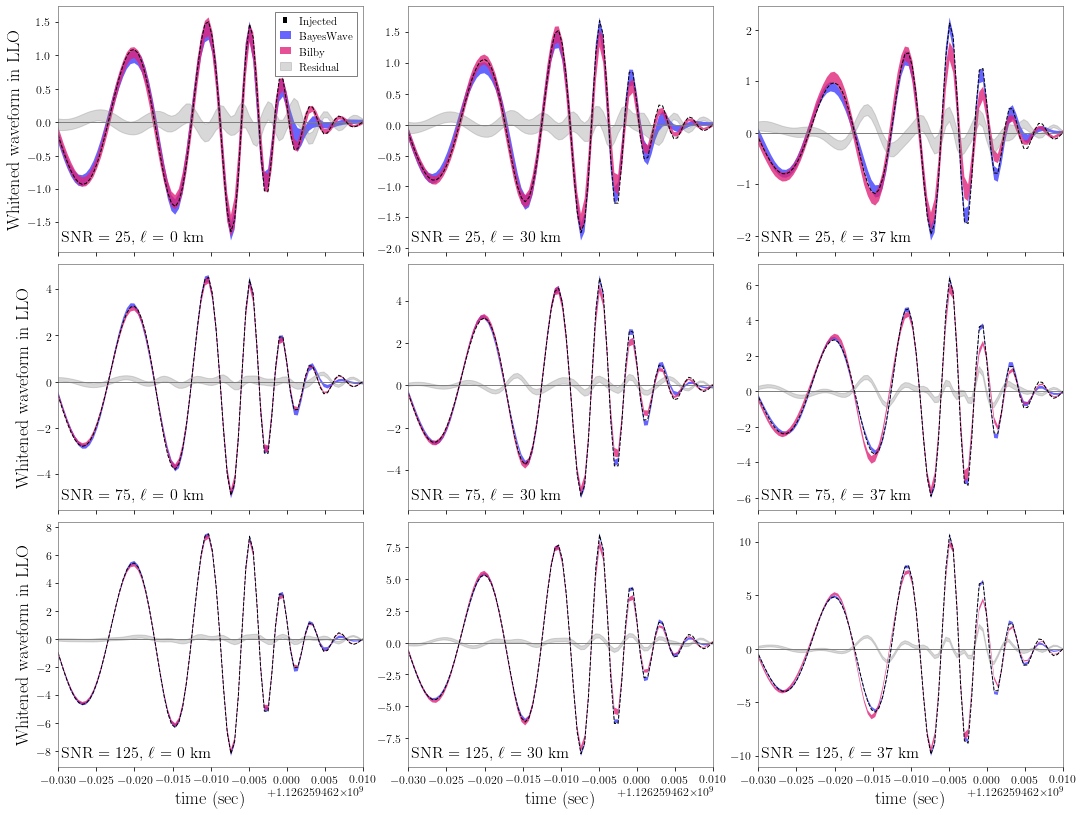

In [38]:
def ComputeResiduals(time_1, h_1, h_1_lo, h_1_hi, time_2, h_2, h_2_lo, h_2_hi):
    
    """ Given two (time, strain) datasets, compute the residual, first
        interpolating onto the same time axis """
    res_med = h_1 - h_2
    res_lo = h_1_lo - h_2
    res_hi = h_1_hi - h_2
    return time_1, res_med, res_lo, res_hi

def PlotMedianDataInset(p, ax, det = "L1", label = "", legend = False):
    """ Given a directory and an axis, plot BW median recovered 
        and injected data """
    
    ## Injected data
    time_inj, data_inj = GetBWInjectedData(p, det = det)
    
    ## Bayeswave data
    time_bw, d1, d2, d3, d4, d5 = GetBWMedianData(p, det = det)
    bw_color = "blue" #"#3ba4d9"
    
    ## Bilby data
    time_bilby, data_bilby, lo_bilby, hi_bilby = GetBilbyData(p, det = det)
    bilby_color = "#e02479" #'#e63984'
    
    ## Plot BW data
    #ax.plot(time_bw, d1, '-', lw = 1.0, alpha = 1.0, color=bw_color, label = 'BayesWave')  
    ax.fill_between(time_bw, d2, d3, alpha = 0.6, color=bw_color, edgecolor=None, linewidth=0.0, label = 'BayesWave') ## 90% interval
    #ax.fill_between(time_bw, d4, d5, alpha = 0.4, color=bw_color, edgecolor=None, linewidth=0.0) ## 50% interval
    
    # Plot Bilby reconstruction
    #ax.plot(time_bilby, data_bilby, '-', color = bilby_color, lw = 1.0, alpha = 0.8, label = 'Bilby') 
    ax.fill_between(time_bilby, lo_bilby, hi_bilby, alpha = 0.8, color=bilby_color, linewidth = 0.0, edgecolor=None, label = 'Bilby') ## 90% interval

    ## Compute and plot the residual
    t_res, res, res_lo, res_hi = ComputeResiduals(time_bw, d1, d2, d3, time_bilby, data_bilby, lo_bilby, hi_bilby)
    ax.fill_between(t_res, res_lo, res_hi, color = 'gray', alpha = 0.3, label = 'Residual')
    ax.axhline(0.0, color = 'gray', lw = 1.0)
    
    ## Plot injected data 
    time_inj, data_inj = GetBWInjectedData(p, det = det)
    ax.plot(time_inj, data_inj, '--', color='black', lw = 1.0, alpha=1.0,  label = 'Injected')
    
    ## Label ell and SNR
    ax.text(0.01, 0.06, label, horizontalalignment='left', verticalalignment='center', transform=ax.transAxes, fontsize=16)
    ax.set_xlim(t_gps - 0.03, t_gps + 0.01)
    ax.grid(False)
    #axins.grid(False)
    
    if legend:
        # get handles and labels
        handles, labels = ax.get_legend_handles_labels()
        print(labels)
        # specify order of items in legend
        order = [0, 1, 2, 3]
        # add legend to plot
        ax.legend([handles[idx] for idx in order],[labels[idx] for idx in order], frameon=True, framealpha = 1.0, fontsize=11, loc='upper right')
    
def PlotInsets(det = "L1"):
    """ Create a plot of injected and recovered BW strains in the time domain """
    
    det_strings = {"L1":"LLO", "H1":"LHO", "V1":"Virgo"}
    mass = 68.0 ## Injected mass
    base_dir = "/home/maria.okounkova/BeyondGRAnalysis/BilbyPE/PHENOM_"
    
    fig, axarr = plt.subplots(3,3, figsize=(18, 14), sharex=True, sharey=False, gridspec_kw={'width_ratios': [1, 1, 1]})
    
    ell = "0p0"
    PlotMedianDataInset(base_dir + "dCS_" + ell + "_25", axarr[0][0], det = det, \
                  label = r'SNR = 25, $\ell$ = %d km' % EllinKm(ell, mass), legend = True)
    PlotMedianDataInset(base_dir + "dCS_" + ell + "_75", axarr[1][0], det = det, \
                   label = r'SNR = 75, $\ell$ = %d km' % EllinKm(ell, mass))
    PlotMedianDataInset(base_dir + "dCS_" + ell + "_125", axarr[2][0], det = det, \
                   label = r'SNR = 125, $\ell$ = %d km' % EllinKm(ell, mass))

    ell = "0p3"
    PlotMedianDataInset(base_dir + "dCS_" + ell + "_25", axarr[0][1], det = det, \
                   label = r'SNR = 25, $\ell$ = %d km' % EllinKm(ell, mass))
    PlotMedianDataInset(base_dir + "dCS_" + ell + "_75", axarr[1][1], det = det, \
                   label = r'SNR = 75, $\ell$ = %d km' % EllinKm(ell, mass))
    PlotMedianDataInset(base_dir + "dCS_" + ell + "_125", axarr[2][1], det = det, \
                   label = r'SNR = 125, $\ell$ = %d km' % EllinKm(ell, mass))
    
    ell = "0p37"
    PlotMedianDataInset(base_dir + "dCS_" + ell + "_25", axarr[0][2], det = det, \
                    label = r'SNR = 25, $\ell$ = %d km' % EllinKm(ell, mass))
    PlotMedianDataInset(base_dir + "dCS_" + ell + "_75", axarr[1][2], det = det, \
                   label = r'SNR = 75, $\ell$ = %d km' % EllinKm(ell, mass))
    PlotMedianDataInset(base_dir + "dCS_" + ell + "_125", axarr[2][2], det = det, \
                   label = r'SNR = 125, $\ell$ = %d km' % EllinKm(ell, mass))

    for i in range(3):
        axarr[-1][i].set_xlabel('time (sec)', fontsize = 18)
        
    for i in range(3):
        axarr[i][0].set_ylabel('Whitened waveform in ' + det_strings[det], ha='center', labelpad = 4.0, rotation='vertical', fontsize=18)
    
    plt.subplots_adjust(wspace=0.15, hspace=0.05)
    plt.savefig('Reconstructions.pdf')
    #plt.tight_layout()
    plt.show()

PlotInsets(det = "L1")

### Plot Bilby & Injected mismatch

In [11]:
def BilbyOverlap(p):
    """ Given a run directory p, read in the injected and recovered hs in the 
        time domain and compute an overlap """
    
    base_dir = '/home/maria.okounkova/BeyondGRAnalysis/BilbyPE/' 
    bi_p = p + '/LI_reconstruct/'
        
    ## Check for file with computed multi-detector bilby overlap 
    name = base_dir + p + "/LI_reconstruct/bilby_overlaps.dat"
    #print(name)

    if not os.path.isfile(name):
        
        print("Generating bilby_overlaps.dat file")
    
        t_inj_H1, h_inj_H1, t_bi_H1, h_bi_H1, d, d = GetBilbyReconstruction(p, det = "H1")
        t_inj_L1, h_inj_L1, t_bi_L1, h_bi_L1, d, d = GetBilbyReconstruction(p, det = "L1")
        t_inj_V1, h_inj_V1, t_bi_V1, h_bi_V1, d, d = GetBilbyReconstruction(p, det = "V1")

        overlap_H1 = ComputeOverlap(t_bi_H1, h_bi_H1, t_inj_H1, h_inj_H1)
        overlap_L1 = ComputeOverlap(t_bi_L1, h_bi_L1, t_inj_L1, h_inj_L1)
        overlap_V1 = ComputeOverlap(t_bi_V1, h_bi_V1, t_inj_V1, h_inj_V1)
        
        overlap_all = ComputeMultiDetectorOverlap(t_bi_H1, h_bi_H1, \
                                  t_bi_L1, h_bi_L1, \
                                  t_bi_V1, h_bi_V1, \
                                  t_inj_H1, h_inj_H1, \
                                  t_inj_L1, h_inj_L1, \
                                  t_inj_V1, h_inj_V1)
        
        print('%f %f %f %f' % (overlap_H1, overlap_L1, overlap_V1, overlap_all))
        f_out = open(name, 'w')
        f_out.write('# Overlap between injected and median reconstructed bilby waveforms \n # overlap_H1 overlap_L1 overlap_V1 overlap_all \n')
        f_out.write('%f %f %f %f' % (overlap_H1, overlap_L1, overlap_V1, overlap_all))
        f_out.close()
    
    overlap_H1, overlap_L1, overlap_V1, overlap_all = np.loadtxt(name, comments="#",usecols=([0, 1, 2, 3]),unpack=True)
    return overlap_all


def PlotBilbyOverlap():
    """ Create a plot of the overlap between BW injected and recovered waveforms as
        a function of SNR. Similar to Fig. 4 in https://arxiv.org/abs/2003.09456 """
    
    base_dir = "/home/maria.okounkova/BeyondGRAnalysis/BilbyPE/PHENOM_"
    mass = 68

    ells = ["0p0", "0p25", "0p3", "0p33", "0p35",  "0p37"]
    ell_vals = np.array([EllinKm(ell, mass) for ell in ells])**4
    snrs = ['25', '50', '75', '100', '125']
    colors = sns.color_palette('mako', n_colors=len(snrs))

    plt.figure(figsize=(8, 4))

    for snr, color in zip(snrs, colors):

        delta_arr = []

        for ell in ells:

            p = "PHENOM_dCS_" + ell + "_" + snr
            overlap = BilbyOverlap(p)
            delta = 1.0 - overlap
            delta_arr.append(delta)

        plt.plot(ell_vals, delta_arr, '-o', color = color, label = 'SNR = ' + snr, markersize = 8, lw = 2.0)

    plt.legend(fontsize=12)
    plt.yscale('log')
    plt.xscale('log')
    plt.ylabel(r'$\Delta$ Bilby, Injected', fontsize=18)
    plt.xlabel(r'($\ell$ [km])${}^4$')
    plt.tight_layout()
    plt.savefig('BilbyMismatch.pdf')
    plt.show()
    
#PlotBilbyOverlap()

### Plot Bilby & Injected and Bayeswave & Injected mismatches

In [12]:
def BayesWaveOverlap(p):
    """ Given a BW run directory p, read in the injected and recovered hs in the 
        time domain and compute an overlap """
    
    ## Check for file with computed multi-detector BW overlap 
    name = GetBWDir(p) + "overlaps.dat"

    if not os.path.isfile(name):
        
        print("Generating overlaps.dat file")
    
        ## Median data and bounds
        t_bw_H1, h_bw_H1, h_bw_2, h_bw_3, h_bw_4, h_bw_5 = GetBWMedianData(p, det = "H1")
        t_bw_L1, h_bw_L1, h_bw_2, h_bw_3, h_bw_4, h_bw_5 = GetBWMedianData(p, det = "L1")
        t_bw_V1, h_bw_V1, h_bw_2, h_bw_3, h_bw_4, h_bw_5 = GetBWMedianData(p, det = "V1")
    
        ## Injected data
        t_inj_H1, h_inj_H1 = GetBWInjectedData(p, det = "H1")
        t_inj_L1, h_inj_L1 = GetBWInjectedData(p, det = "L1")
        t_inj_V1, h_inj_V1 = GetBWInjectedData(p, det = "V1")
    
        overlap_H1 = ComputeOverlap(t_bw_H1, h_bw_H1, t_inj_H1, h_inj_H1)
        overlap_L1 = ComputeOverlap(t_bw_L1, h_bw_L1, t_inj_L1, h_inj_L1)
        overlap_V1 = ComputeOverlap(t_bw_V1, h_bw_V1, t_inj_V1, h_inj_V1)
        
        overlap_all = ComputeMultiDetectorOverlap(t_bw_H1, h_bw_H1, \
                                  t_bw_L1, h_bw_L1, \
                                  t_bw_V1, h_bw_V1, \
                                  t_inj_H1, h_inj_H1, \
                                  t_inj_L1, h_inj_L1, \
                                  t_inj_V1, h_inj_V1)
        
        print('%f %f %f %f' % (overlap_H1, overlap_L1, overlap_V1, overlap_all))
        f_out = open(name, 'w')
        f_out.write('# Overlap between injected and median reconstructed BW waveforms \n # overlap_H1 overlap_L1 overlap_V1 overlap_all \n')
        f_out.write('%f %f %f %f' % (overlap_H1, overlap_L1, overlap_V1, overlap_all))
        f_out.close()
    
    overlap_H1, overlap_L1, overlap_V1, overlap_all = np.loadtxt(name, comments="#",usecols=([0, 1, 2, 3]),unpack=True)
    return overlap_all

def PlotBayesWaveBilbyOverlap():
    """ Create a plot of the overlap between BW injected and recovered waveforms and 
        Bilby injected and recovered waveforms as
        a function of SNR. Similar to Fig. 4 in https://arxiv.org/abs/2003.09456 """
    
    base_dir = "/home/maria.okounkova/BeyondGRAnalysis/BilbyPE/PHENOM_"
    mass = 68

    ells = ["0p0", "0p25", "0p3", "0p33", "0p35",  "0p37"]
    colors = sns.color_palette('mako', n_colors=len(ells))
    snrs = [25, 50, 75, 100, 125]

    fig, ax = plt.subplots(2, figsize=(8, 8), sharex = True)
    
    for ell, color in zip(ells, colors):
        
        bilby_delta_arr = []
        bw_delta_arr = []

        for snr in snrs:

            ## Bayeswave overlap
            p = base_dir + "dCS_" + ell + "_" + str(snr)
            overlap = BayesWaveOverlap(p)
            bw_delta = 1.0 - overlap
            bw_delta_arr.append(bw_delta)

            ## Bilby overlap
            p = "PHENOM_dCS_" + ell + "_" + str(snr)
            overlap = BilbyOverlap(p)
            bilby_delta = 1.0 - overlap
            bilby_delta_arr.append(bilby_delta)

        ax[0].plot(snrs, bw_delta_arr, '-o', color = color,  lw = 2.0, alpha = 0.8, label = "%d" % EllinKm(ell, mass), markersize = 8)
        ax[1].plot(snrs, bilby_delta_arr, '-o', color = color, lw = 2.0, label = "$\ell$ = %d km" % EllinKm(ell, mass), markersize = 8)

    ## Add in 1/SNR^2 curve 
    def func(x, a, c):
        return a*x**-2 + c
    
    popt, pcov = curve_fit(func, snrs, bw_delta_arr)
    snrs_plot = np.linspace(snrs[0], snrs[-1], 100)
    ax[0].plot(snrs_plot, func(snrs_plot, *popt), color='#2712c4', label = r'$\sim \mathrm{SNR}^{-2}$', alpha = 0.2, lw = 10.0, ls = '--')
    
    
    #snr_curve = SNRS**-2.0
    #ax[0].plot(SNRS, snr_curve*10, color='#f0568f', label = r'$\sim \mathrm{SNR}^{-2}$', alpha = 0.3, lw = 10.0)
    
    plt.subplots_adjust(hspace=0.0)
    
    leg = ax[0].legend(fontsize=16, ncol=2, title = r'$\ell$ [km]', \
                       columnspacing=0.8, labelspacing = 0.4, framealpha = 1.0, frameon = True, loc = 'lower left')
    plt.setp(leg.get_title(),fontsize=16)
    
    ax[0].set_yscale('log')
    ax[1].set_yscale('log')
    ax[0].set_xscale('log')
    ax[1].set_xscale('log')

    ax[0].set_ylabel(r'$\Delta$ BayesWave, Injected', fontsize=18)
    ax[1].set_ylabel(r'$\Delta$ Bilby, Injected', fontsize=18)
    ax[1].set_xlabel('SNR', fontsize=18)
    #plt.savefig('BayeswaveBilbyDeltas.pdf')
    
    ax[0].tick_params(axis='y', labelsize=16)
    ax[1].tick_params(axis='y', labelsize=16)
      
    ax[0].tick_params(axis = 'x', direction='inout', length=10)
    ax[1].tick_params(axis = 'x', direction='out', length=10, width=1, colors='k',
               grid_color='b', grid_alpha=0.5, labelsize=16)
    
    ax[0].set_ylim(1e-4, 1e-2)
    ax[1].set_ylim(5e-5, 2e-2)
    for axis in ax:
        axis.grid(True, alpha=0.7, lw = 0.6, ls = '--', color = 'gray')
    plt.savefig('Mismatches.pdf') 
    plt.show()
    
#PlotBayesWaveBilbyOverlap()

### Plot Bayeswave & Bilby mismatch

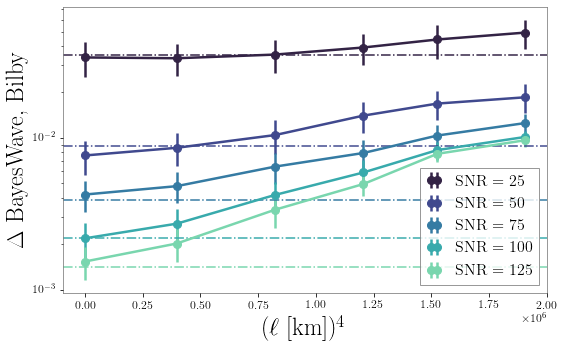

In [39]:
def GetBilbyDraws(p):

    """ Get waveform draws for bilby """
    ## Get time array
    t_H1 = GetBilbyTimes(p, det = 'H1')
    t_L1 = GetBilbyTimes(p, det = 'L1')
    t_V1 = GetBilbyTimes(p, det = 'V1')
    
    file = p + '/LI_reconstruct/waveforms_samples.npy'
    waveform_samples = np.load(file)
    
    ### We called reclal.py with ifos H1 L1 V1
    H1_samples = waveform_samples[0]
    L1_samples = waveform_samples[1]
    V1_samples = waveform_samples[2]
    
    return t_H1, H1_samples, t_L1, L1_samples, t_V1, V1_samples
    
def GetBayesWaveDraws(p):
    
    ## Get time array
    t_H1 = GetBWTimes(p, det = 'H1')
    t_L1 = GetBWTimes(p, det = 'L1')
    t_V1 = GetBWTimes(p, det = 'V1')
    
    H1_samples = np.loadtxt(GetBWDir(p) + "post/signal/signal_recovered_whitened_waveform_H1.dat")
    L1_samples = np.loadtxt(GetBWDir(p) + "post/signal/signal_recovered_whitened_waveform_L1.dat")
    V1_samples = np.loadtxt(GetBWDir(p) + "post/signal/signal_recovered_whitened_waveform_V1.dat")

    return t_H1, H1_samples, t_L1, L1_samples, t_V1, V1_samples

def GetBilbyBWMismatch(base_dir):
    
    name = base_dir + "/bw_li_output/LI_reconstruct/mismatch_errorbars.txt"
    if not os.path.isfile(name):
        
        print("Generating " + name)
    
        ## BW recovered data
        t_bw_H1, h_bw_H1, h_bw_2_H1, h_bw_3_H1, h_bw_4, h_bw_5 = GetBWMedianData(base_dir, det = "H1")
        t_bw_L1, h_bw_L1, h_bw_2_L1, h_bw_3_L1, h_bw_4, h_bw_5 = GetBWMedianData(base_dir, det = "L1")
        t_bw_V1, h_bw_V1, h_bw_2_V1, h_bw_3_V1, h_bw_4, h_bw_5 = GetBWMedianData(base_dir, det = "V1")
        
        det = "L1"
        
        ## Bilby Draws
        t_H1, H1_samples, t_L1, L1_samples, t_V1, V1_samples = GetBilbyDraws(base_dir)
        
        ## Bayeswave Draws
        bwt_H1, bwH1_samples, bwt_L1, bwL1_samples, bwt_V1, bwV1_samples = GetBayesWaveDraws(base_dir)
            
        ## For each of the draws, compute an overlap
        N = 200
        mismatches = np.zeros(N)
        for i in range(N):
            print(i, end = " ")
            overlap = ComputeMultiDetectorOverlap( \
                                  bwt_H1, bwH1_samples[i], \
                                  bwt_L1, bwL1_samples[i], \
                                  bwt_V1, bwV1_samples[i], \
                                  t_H1, H1_samples[i], \
                                  t_L1, L1_samples[i], \
                                  t_V1, V1_samples[i])
            mismatches[i] = 1 - overlap
        np.savetxt(name, mismatches)

    mismatch_arr = np.loadtxt(name)
    return mismatch_arr

def PlotBilbyBWMismatch():
    
    base_dir = "/home/maria.okounkova/BeyondGRAnalysis/BilbyPE/PHENOM_"
    
    fig = plt.figure(figsize=(8, 5))
    plt.xlabel(r'($\ell$ [km])${}^4$')
    plt.ylabel('$\Delta$ BayesWave, Bilby')
    plt.yscale('log')
    
    ells = ["0p0", "0p25", "0p3", "0p33", "0p35", "0p37"]
    ells_km = np.array([EllinKm(l, 68) for l in ells])**4
    snrs = ['25', '50', '75', '100', '125']
    colors = sns.color_palette('mako', n_colors=len(snrs))
    
    for snr, color in zip(snrs, colors):
        
        mismatch_meds = []
        mismatch_errors = []
        
        for ell in ells:
            
            p = base_dir + "dCS_" + ell + "_" + snr
            mismatches = GetBilbyBWMismatch(p)
            mismatch_meds.append(np.median(mismatches))
            mismatch_errors.append(np.std(mismatches))
            #print(snr + ' ' + ell)

        #print(mismatch_meds, mismatch_errors)
        if snr in ['25', '50', '75', '100', '125']:
            plt.axhline(22/int(snr)**2, color = color, ls = '-.', lw = 1.5)
        #    #plt.plot(ells_km, mismatches, '-o', lw = 2.0, markersize=8, color = color, label = 'SNR = ' + snr)
        #plt.plot(ells_km, mismatches, marker = 'o', lw = 2.5, markersize=8, color = color, label = 'SNR = ' + snr)
        plt.errorbar(ells_km, mismatch_meds, yerr = mismatch_errors, \
                    marker = 'o', lw = 2.5, markersize=8, color = color, label = 'SNR = ' + snr)
    

    plt.grid()
    plt.legend(fontsize=16)
    plt.tight_layout()
    plt.savefig('BWLIMismatch.pdf') 
    plt.show()

PlotBilbyBWMismatch()

### Plot evidences

1281133.53999 1281134.67429
1281066.9002 1281073.11741
1281033.07737 1281041.44574


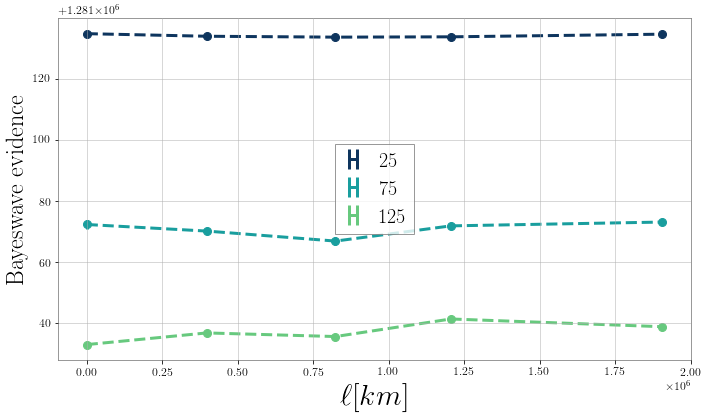

In [12]:
def GetEvidenceTemps(base_dir):
    """ evidence.dat file looks like 
        signal 857281.232665 0.0105919
        glitch 0 0
        noise 0 0
        
        Here we're going to return the (0,1)
        entry, which in this case is 857281.232665
    """
    f = '/home/maria.okounkova/BeyondGRAnalysis/BilbyPE/' + base_dir + "/BayesWave/Run/trigtime_1126259462.000000000_0.0_0.0_0/signal_evidence.dat"
    temp, evidence = np.loadtxt(f, comments="#",usecols=([0, 1]),unpack=True)
    print(len(temp))
    
    return temp, evidence

def GetEvidence(base_dir):
    """ evidence.dat file looks like 
        signal 857281.232665 0.0105919
        glitch 0 0
        noise 0 0
        
        Here we're going to return the (0,1)
        entry, which in this case is 857281.232665
    """
    
    f = '/home/maria.okounkova/BeyondGRAnalysis/BilbyPE/' + base_dir + "/BayesWave/Run/trigtime_1126259462.000000000_0.0_0.0_0/evidence.dat"
 
    ev, variance = np.loadtxt(f, comments="#",usecols=([1, 2]),unpack=True)
    
    ev = ev[0]
    ev_err = sqrt(variance[0])
    
    return ev, ev_err

def PlotBWEvidence():
    
    fig = plt.figure(figsize=(10, 6))
    
    ell = ["0p0", "0p25", "0p3", "0p33", "0p37"]
    ell_km = np.array([EllinKm(l, 68) for l in ell])**4
    snrs = ['25', '75', '125'] 
    colors = ["#0e355e", "#199e9e", "#67c97e"]
    
    for SNR, color in zip(snrs, colors):
    
        BW_Evidence = np.zeros(len(ell))
        BW_Evidence_err = np.zeros(len(ell))

        for i, l in enumerate(ell):
            base_dir = 'PHENOM_dCS_' + l + '_' + SNR
            ev, ev_err = GetEvidence(base_dir) 
            BW_Evidence[i] = ev
            BW_Evidence_err[i] = ev_err
    
        plt.errorbar(ell_km, BW_Evidence, yerr=BW_Evidence_err, linestyle='--', label=SNR, linewidth=3, color = color)
        plt.plot(ell_km, BW_Evidence, 'o', markersize=8, color = color)
        print(min(BW_Evidence), max(BW_Evidence))
    
    plt.xlabel(r'$\ell [km]$', fontsize=30)
    plt.ylabel('Bayeswave evidence')

    plt.legend(fontsize=20)
    plt.tight_layout()
    plt.savefig('BayesWaveEvidence.pdf') 
    plt.show()

PlotBWEvidence()

### Plot Bayes factors as a function of $\ell$ for Bilby Runs

0p0
0.297042
0p25
0.299385
0p3
0.305257
0p33
0.325573
0p35
0.33249
0p37
0.350839
[-51.028021, -54.154522, -64.237298, -83.239702, -100.283522, -117.185273]
[-3001.530233, -3001.493688, -3001.417232, -3001.327918, -3001.246504, -3001.149646]
[2950.502212, 2947.339166, 2937.179934, 2918.088216, 2900.962983, 2883.964373]


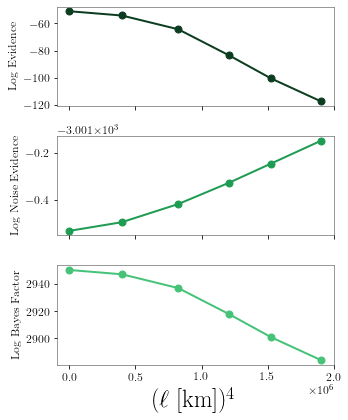

In [13]:
def PlotBayesEll():

    base_dir = "/home/maria.okounkova/BeyondGRAnalysis/BilbyPE/"
    mass = 68

    ells = ["0p0", "0p25", "0p3", "0p33", "0p35", "0p37"]
    ell_vals = [EllinKm(ell, mass) for ell in ells]
    snr = 75

    log_evidences = [] 
    log_evidence_errs = [] 
    log_noise_evidences = [] 
    log_bayes_factors = []

    for ell in ells:

        print(ell)
        p = base_dir + "PHENOM_dCS_" + ell + "_" + str(snr) + "/outdir_fref"
        log_evidence, log_evidence_err, log_noise_evidence, log_bayes_factor = GetEvidences(p)
        print(log_evidence_err)
        
        log_evidences.append(log_evidence)
        log_noise_evidences.append(log_noise_evidence)
        log_bayes_factors.append( log_bayes_factor)

    fig, axes = plt.subplots(3, figsize=(5,6), sharex = True)

    print(log_evidences)
    print(log_noise_evidences)
    print(log_bayes_factors)
    
    axes[0].plot(np.array(ell_vals)**4, log_evidences, '-o', color = '#0c3d20', markersize = 7, lw = 2.0)
    axes[1].plot(np.array(ell_vals)**4, log_noise_evidences, '-o', color = '#1f9c53', markersize = 7, lw = 2.0)
    axes[2].plot(np.array(ell_vals)**4, log_bayes_factors, '-o', color = '#46c279',  markersize = 7, lw = 2.0)

    fs = 12
    axes[0].set_ylabel('Log Evidence', fontsize=fs)
    axes[1].set_ylabel('Log Noise Evidence', fontsize=fs)
    axes[2].set_ylabel('Log Bayes Factor', fontsize=fs)
    

    for ax in axes:
        ax.tick_params(axis='x', which='both', bottom=True, top=False) 
        ax.grid()

    plt.subplots_adjust(hspace=0.18)
    plt.xlabel(r'($\ell$ [km])${}^4$')
    plt.tight_layout()
    plt.savefig('BayesEll.pdf')
    plt.show()
    
PlotBayesEll()

### Plot Bayes factors as a function of SNR Bilby runs

Generating evidences.dat from result.json file
0p0 25 297.97039
0p0 75 2950.502212
Generating evidences.dat from result.json file
0p0 125 8279.551585
Generating evidences.dat from result.json file
0p25 25 298.065265
0p25 75 2947.339166
Generating evidences.dat from result.json file
0p25 125 8271.325564
Generating evidences.dat from result.json file
0p3 25 295.874552
0p3 75 2937.179934
Generating evidences.dat from result.json file
0p3 125 8246.209816
Generating evidences.dat from result.json file
0p37 25 283.814653
0p37 75 2883.964373
Generating evidences.dat from result.json file
0p37 125 8126.191913


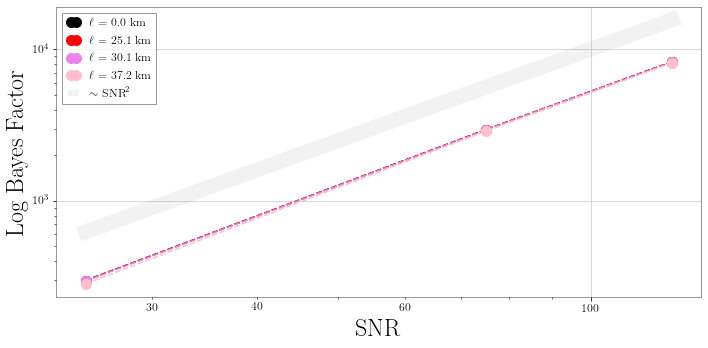

In [14]:
def PlotBayesSNR():
    """ Plot Bayes factors for various dCS parameters as a function of SNR """
    
    base_dir = "/home/maria.okounkova/BeyondGRAnalysis/BilbyPE/"
    mass = 68
    
    ells = ["0p0", "0p25", "0p3", "0p37"]
    colors = ['black', 'red', 'violet', 'pink', 'lightblue', 'orange']
    snrs = [25, 75, 125]
    
    plt.figure(figsize=(10, 5))
    
    for ell, color in zip(ells, colors):

        bayes_arr = []

        for snr in snrs:

            p = base_dir + "PHENOM_dCS_" + ell + "_" + str(snr)  + "/outdir_fref"
            log_evidence, log_evidence_err, log_noise_evidence, log_bayes_factor = GetEvidences(p)
            print(ell, snr, log_bayes_factor)
            bayes_arr.append(log_bayes_factor)

        plt.plot(snrs, bayes_arr, '--o', color = color, label = "$\ell$ = %.1f km" % EllinKm(ell, mass), markersize = 10)
        
    ## Add in 1/SNR^2 curve 
    SNRS = np.linspace(snrs[0], snrs[-1], 100)
    snr_curve = SNRS**2.0
    plt.plot(SNRS, snr_curve, color='gray', label = r'$\sim \mathrm{SNR}^{2}$', alpha = 0.1, lw = 15.0)

    plt.legend()
    plt.yscale('log')
    plt.xscale('log')
    plt.ylabel('Log Bayes Factor')
    plt.xlabel('SNR')
    plt.tight_layout()
    plt.savefig('BayesSNR.pdf')
    plt.show()
    
PlotBayesSNR()